In [3]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from deep_translator import GoogleTranslator
import re
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [202]:
def fetch_and_process_data(url, year_start, year_end):
    response = requests.get(url)
    data = response.content

    soup = BeautifulSoup(data, 'lxml')
    pre_tag = soup.find('pre')
    table_text = pre_tag.get_text()

    lines = table_text.split('\n')
    data = []
    # lets try and defines the 'columns' for the dataframe
    columns = ['Location', '*']
    for year in range(year_start, year_end + 1):
        columns.extend([f'{year}_Month', f'{year}_Day'])
    columns.extend(['平年値_Month', '平年値_Day', '代替種目'])

    # Extract data rows
    for line in lines:
        if line.strip() and not line.startswith('地点名') and not line.startswith('月'):
            row_data = line.split()
            data.append(row_data)
            
    # For some reason the previous code still didn't eliminate the lines starting with month/day so we filter out the data list instead
    data_filtered = [row for row in data if not row[0].startswith('月') and not row[0].startswith('地点名')]

    # Function to insert 'Not currently under observation' as the second element where '*' is missing
    def insert_star(lst):
        if lst[1] != '*':
            lst.insert(1, 'Not currently under observation')
        return lst

    modified_data = [insert_star(row) for row in data_filtered]
    
    # Now that we fixed that I also noticed that the observations where the date is missing are filled out with a '-' value
    # however because these values are present only under the 'day' columns and this will create a problem later on when we
    # try to combine the day and month values, lets try and fix that

    modified_data2 = []
    for row_data in modified_data:
        modified_row = []
        for item in row_data:
            if item == '-':
                modified_row.append('-')
                modified_row.append(item)
            else:
                modified_row.append(item)
        modified_data2.append(modified_row)

    df = pd.DataFrame(modified_data2, columns=columns)
    # we will drop the 'average value' and 'alternative species' bcz we will not be needing them
    df = df.iloc[:, :-3]

    # Combine month and day columns for each year
    for year in range(year_start, year_end + 1):
        month_col = f'{year}_Month'
        day_col = f'{year}_Day'
        combined_col = f'{year}'
        df[combined_col] = df[month_col] + ' ' + df[day_col]
        df.drop([month_col, day_col], axis=1, inplace=True)

    # attetion! now we have '- -' values where the date is missing lets replace them with NaN
    df.replace('- -', np.nan, inplace=True)

    def translate_text(text):
        try:
            translated = GoogleTranslator(source='ja', target='en').translate(text)
            return translated
        except Exception as e:
            print(f"Translation error: {e}")
            return text

    df['Location'] = df['Location'].apply(translate_text)

    return df

In [252]:
# List of URLs and year ranges to process
urls = [
    ('https://www.data.jma.go.jp/sakura/data/sakura003_04.html', 1991, 2000),
    ('https://www.data.jma.go.jp/sakura/data/sakura003_05.html', 2001, 2010),
    ('https://www.data.jma.go.jp/sakura/data/sakura003_06.html', 2011, 2020),
    ('https://www.data.jma.go.jp/sakura/data/sakura003_07.html', 2021, 2024)
    # Maybe ddd more URLs and their corresponding year ranges?
]

final_df = pd.DataFrame()

# Fetch and process data from all URLs
for url, year_start, year_end in urls:
    df = fetch_and_process_data(url, year_start, year_end)
    if final_df.empty:
        final_df = df
    else:
        df.drop(columns=['*'], inplace=True)  # Drop '*' columns from the previous dataframes bcz it is essentially the same
        final_df = pd.merge(final_df, df, on='Location', how='outer')

In [253]:
final_df.head()

,Location,*,1991,1992,1993,1994,1995,1996,1997,1998,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Wakkanai,*,5 14,5 17,5 15,5 16,5 8,5 20,5 15,5 11,...,5 3,5 13,5 9,5 12,5 7,5 10,5 8,5 6,5 3,5 1
1,Rumoi,Not currently under observation,5 7,5 12,5 12,5 14,5 5,5 20,5 12,4 29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Asahikawa,*,5 5,5 9,5 8,5 11,5 2,5 7,5 5,4 23,...,4 27,5 3,5 3,4 30,5 1,5 3,4 29,4 26,4 25,4 24
3,Abashiri,*,5 8,5 13,5 20,5 13,5 8,5 24,5 12,4 28,...,4 30,5 8,5 5,5 2,5 5,5 7,5 6,4 27,4 28,4 28
4,Sapporo,*,5 2,5 4,5 6,5 6,5 1,5 5,5 1,4 23,...,4 22,4 25,4 28,4 26,4 24,4 30,4 22,4 23,4 15,4 18


In [254]:
final_df.shape

(102, 36)

before we continue, it looks like some observation contain the # symbol, my first approach to this was to simply remove the symbol but after a second look at the information provided on the JMA website it looks like 

The "#" indicates what was observed in the previous year -> in other words if we are observng the year 1992, a value of 24/12 refers to 24/12/1991 and not 24/12/1992

The new approach now is to first identify the obsevations with the # symbol, save the info about the location and the corresponding year then afterwards process the data and finally use the previously saved info to change the value of the year 

In [255]:
def has_hash(x):
    return isinstance(x, str) and '#' in x

mask = final_df.applymap(has_hash)

# Extract the relevant rows and columns with # 
hash_info = final_df[mask].copy()
hash_info['Location'] = final_df['Location']
hash_info = hash_info.melt(id_vars=['Location'], var_name='year', value_name='peak_bloom_date')
hash_info = hash_info.dropna().reset_index(drop=True)

# Remove `#` from peak_bloom_date
hash_info['peak_bloom_date'] = hash_info['peak_bloom_date'].str.replace('#', '')
hash_info['year'] = hash_info['year'].astype(int)

hash_info

,Location,year,peak_bloom_date
0,Nago,1999,12 28
1,Miyakojima,2003,12 30
2,Naha,2010,12 31
3,Ishigaki Island,2012,12 24
4,Naha,2013,12 28


In [256]:
for column in final_df.columns:
    if column not in ['Location', '*']:
        final_df[column] = final_df[column].apply(lambda x: x.replace('#', '') if isinstance(x, str) and '#' in x else x)

In [257]:
# Fixing the format to mm-dd
for year in range(1991, 2025):  # assuming columns are from '1991_Month' to '2024_Day'
    # Replace any leading spaces (if any)
    final_df[f'{year}'] = final_df[f'{year}'].str.replace(r'^\s+', '', regex=True)
    final_df[f'{year}'] = pd.to_datetime(final_df[f'{year}'], format='%m %d').dt.strftime('%m-%d')

In [258]:
final_df.head()

,Location,*,1991,1992,1993,1994,1995,1996,1997,1998,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Wakkanai,*,05-14,05-17,05-15,05-16,05-08,05-20,05-15,05-11,...,05-03,05-13,05-09,05-12,05-07,05-10,05-08,05-06,05-03,05-01
1,Rumoi,Not currently under observation,05-07,05-12,05-12,05-14,05-05,05-20,05-12,04-29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Asahikawa,*,05-05,05-09,05-08,05-11,05-02,05-07,05-05,04-23,...,04-27,05-03,05-03,04-30,05-01,05-03,04-29,04-26,04-25,04-24
3,Abashiri,*,05-08,05-13,05-20,05-13,05-08,05-24,05-12,04-28,...,04-30,05-08,05-05,05-02,05-05,05-07,05-06,04-27,04-28,04-28
4,Sapporo,*,05-02,05-04,05-06,05-06,05-01,05-05,05-01,04-23,...,04-22,04-25,04-28,04-26,04-24,04-30,04-22,04-23,04-15,04-18


In [259]:
# For the purposes of the analysis it might be a good idea to reshape the data so that we have the 'peak_bloom_date' as one column
id_vars = ['Location', '*']
value_vars = [col for col in final_df.columns if col not in id_vars]
    
df_melted = final_df.melt(id_vars=id_vars, value_vars=value_vars, var_name='year', value_name='peak_bloom_date') # While we're at it maybe also extract the year column
    
df_melted['year'] = df_melted['year'].astype(str).str.extract('(\d{4})').astype(int)
df_melted['peak_bloom_date'] = df_melted['peak_bloom_date'].apply(lambda x: f"{x.replace('-', ' ')}" if pd.notna(x) else x)
df_melted['peak_bloom_date'] = df_melted.apply(lambda row: f"{row['year']} {row['peak_bloom_date']}" if pd.notna(row['peak_bloom_date']) else np.nan, axis=1)
df_melted['peak_bloom_date'] = pd.to_datetime(df_melted['peak_bloom_date'], format='%Y %m %d', errors='coerce')
# the 'day of the year' feature could also be useful for our analysis
df_melted['bloom_day_of_year'] = df_melted['peak_bloom_date'].dt.dayofyear
    
df_reshaped = df_melted[['Location', '*', 'year', 'peak_bloom_date', 'bloom_day_of_year']].sort_values(by=['Location', 'year'])
    

In [260]:
df_reshaped.head()

,Location,*,year,peak_bloom_date,bloom_day_of_year
3,Abashiri,*,1991,1991-05-08,128.0
105,Abashiri,*,1992,1992-05-13,134.0
207,Abashiri,*,1993,1993-05-20,140.0
309,Abashiri,*,1994,1994-05-13,133.0
411,Abashiri,*,1995,1995-05-08,128.0


In [261]:
hash_info

,Location,year,peak_bloom_date
0,Nago,1999,12 28
1,Miyakojima,2003,12 30
2,Naha,2010,12 31
3,Ishigaki Island,2012,12 24
4,Naha,2013,12 28


In [267]:
# Now bck to our # issue, this time let's fix the year problem

merged_df = df_reshaped.merge(hash_info, on=['Location', 'year'], how='left', suffixes=('', '_hash'))
# If there's a match, `peak_bloom_date_hash` will not be NaN, indicating the presence of a #
# Then we can adjust the year and peak_bloom_date where there is a match
merged_df['year'] = merged_df.apply(
    lambda row: row['year'] - 1 if pd.notna(row['peak_bloom_date_hash']) else row['year'], 
    axis=1
)
merged_df['peak_bloom_date'] = merged_df.apply(
    lambda row: row['peak_bloom_date'] - pd.DateOffset(years=1) if pd.notna(row['peak_bloom_date_hash']) else row['peak_bloom_date'], 
    axis=1
)
merged_df.drop(columns=['peak_bloom_date_hash'], inplace=True)

In [275]:
# Now let's have a look at the '*' column, according to the description on the JMA website this column indicates if the location is 
# currently under observation or not, let's do some slight formatting to make that more clear

merged_df.rename({'*': 'Observation_Status'}, axis=1, inplace=True)
merged_df['Observation_Status'] = merged_df['Observation_Status'].replace({
        '*': 'Observed',
        'Not currently under observation': 'Not Observed'
    })

In [276]:
merged_df.head()

,Location,Observation_Status,year,peak_bloom_date,bloom_day_of_year
0,Abashiri,Observed,1991,1991-05-08,128.0
1,Abashiri,Observed,1992,1992-05-13,134.0
2,Abashiri,Observed,1993,1993-05-20,140.0
3,Abashiri,Observed,1994,1994-05-13,133.0
4,Abashiri,Observed,1995,1995-05-08,128.0


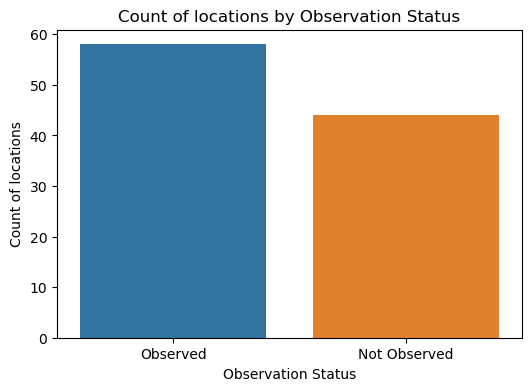

In [277]:
# lets have a look at how many locations are not currently under observation, and see if we should keep them in the analysis
unique_status_counts = merged_df.groupby('Location')['Observation_Status'].first().value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=unique_status_counts.index, y=unique_status_counts.values)
plt.title('Count of locations by Observation Status')
plt.xlabel('Observation Status')
plt.ylabel('Count of locations')
plt.show()

In [65]:
unique_status_counts

Observed        58
Not Observed    44
Name: Observation_Status, dtype: int64

Okey it looks like there's quiete an important number of locations that are no longer under observations, so it doesn't seem very wise to just drop them all, instead we will keep the information regarding the loations but only up until the point where we have observables information

In [278]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3468 entries, 0 to 3467
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Location            3468 non-null   object        
 1   Observation_Status  3468 non-null   object        
 2   year                3468 non-null   int64         
 3   peak_bloom_date     2656 non-null   datetime64[ns]
 4   bloom_day_of_year   2656 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 162.6+ KB


In [279]:
# Identify the latest year of observation for each location
latest_observed_year = merged_df[merged_df['Observation_Status'] == 'Observed'].groupby('Location')['year'].max()

latest_observed_year_df = latest_observed_year.reset_index()
latest_observed_year_df.columns = ['Location', 'latest_year']

# Merge this df with the original df
df_filtered = pd.merge(merged_df, latest_observed_year_df, on='Location', how='left')

# Filter rows where the year is less than or equal to the latest observed year
df_filtered = df_filtered[df_filtered['year'] <= df_filtered['latest_year']]

df_filtered = df_filtered.drop(columns=['latest_year'])

In [280]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1972 entries, 0 to 3399
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Location            1972 non-null   object        
 1   Observation_Status  1972 non-null   object        
 2   year                1972 non-null   int64         
 3   peak_bloom_date     1971 non-null   datetime64[ns]
 4   bloom_day_of_year   1971 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 92.4+ KB


In [281]:
df_filtered[df_filtered.isnull().any(axis=1)]

,Location,Observation_Status,year,peak_bloom_date,bloom_day_of_year
1458,Minamidaito Island,Observed,2021,NaT,NaN


Perfect, now we have all the correct data with one observation missing for 'Minamidaito Island' for the year 2021, since that's the only observations we can simply impute it using the mean value of the peak_bloom_date in this specific location

In [282]:
minamidaito_data = df_filtered[df_filtered['Location'] == 'Minamidaito Island']

# Calculate mean of the 'bloom_day_of_year' column for easier computation since its a numerical value, and because we didn't want 
# to include the year in the calculation because it influences the mean value
mean_bloom_day_of_year = minamidaito_data['bloom_day_of_year'].mean()

# now we fill in the missing value in 'bloom_day_of_year' with the calculated mean
df_filtered.loc[(df_filtered['Location'] == 'Minamidaito Island') & (df_filtered['bloom_day_of_year'].isna()), 'bloom_day_of_year'] = mean_bloom_day_of_year

# fill in the missing 'peak_bloom_date' using the 'bloom_day_of_year' and our target year 2021
df_filtered['peak_bloom_date'] = df_filtered.apply(
    lambda row: (pd.to_datetime(f'2021-01-01') + pd.to_timedelta(row['bloom_day_of_year'] - 1, unit='D')).date()
    if pd.isna(row['peak_bloom_date']) and row['Location'] == 'Minamidaito Island' else row['peak_bloom_date'],
    axis=1
)

In [283]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1972 entries, 0 to 3399
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Location            1972 non-null   object        
 1   Observation_Status  1972 non-null   object        
 2   year                1972 non-null   int64         
 3   peak_bloom_date     1972 non-null   datetime64[ns]
 4   bloom_day_of_year   1972 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 92.4+ KB


no more missing values 

# Additional data

In [72]:
# let's try and add some supportive information to our data, such as lattitude, longitude and Temperature data

In [284]:
df_filtered.Location.unique()

array(['Abashiri', 'Akita', 'Aomori', 'Asahikawa', 'Choshi', 'Fukui',
       'Fukuoka', 'Fukushima', 'Gifu', 'Hakodate', 'Hikone', 'Hiroshima',
       'Ishigaki Island', 'Kagoshima', 'Kanazawa', 'Kobe', 'Kochi',
       'Kofu', 'Kumagaya', 'Kumamoto', 'Kushiro', 'Kyoto', 'Maebashi',
       'Matsue', 'Matsuyama', 'Minamidaito Island', 'Mito', 'Miyakojima',
       'Miyazaki', 'Morioka', 'Muroran', 'Nagano', 'Nagasaki', 'Nagoya',
       'Naha', 'Nara', 'Naze', 'Niigata', 'Obihiro', 'Oita', 'Okayama',
       'Osaka', 'Saga', 'Sapporo', 'Sendai', 'Shimonoseki', 'Shizuoka',
       'Takamatsu', 'Tokushima', 'Tokyo', 'Tottori', 'Toyama', 'Tsu',
       'Utsunomiya', 'Wakayama', 'Wakkanai', 'Yamagata', 'Yokohama'],
      dtype=object)

In [286]:
# source : https://2015.index.okfn.org/place/japan/postcodes/
lat_long_data = pd.read_csv('lat_long_data.csv')

In [287]:
lat_long_data.head()

,location,lat,long
0,Wakkanai,45.415000,141.678889
1,Rumoi,43.946111,141.631944
2,Asahikawa,43.756944,142.372222
3,Abashiri,44.017778,144.279722
4,Sapporo,43.060000,141.328611


In [288]:
lat_long_data.shape

(111, 3)

In [289]:
# the number of locations is a bit high, this might indicate that this dataset has some duplicates, let;s verify that
duplicate_locations = lat_long_data[lat_long_data.duplicated(subset='location', keep=False)]
print(duplicate_locations)

     location        lat        long
7     Kushiro  42.985833  144.377778
8     Kushiro  42.953056  144.437500
10    Muroran  42.311667  140.975278
11    Muroran  42.323611  140.970000
26     Sendai  38.261944  140.896667
27     Sendai  38.262222  140.896667
47     Nagoya  35.167778  136.965556
48     Nagoya  35.168333  136.964722
65    Tottori  35.487778  134.238333
66    Tottori  35.530833  134.199444
81    Izuhara  34.197778  129.291944
82    Izuhara  34.153333  129.222778
91  Yakushima  30.385556  130.659167
92  Yakushima  30.383056  130.659167
98      Kochi  33.568056  133.549444
99      Kochi  33.568333  133.549167


This confirms our suspicion, there seems to be multiple values for the same locations, since these values only differ slightly we can safely disregard some of them as duplicates

In [290]:
#lets keep the first occurence of each duplicated value
lat_long_data_unique = lat_long_data.drop_duplicates(subset='location', keep='first')

In [291]:
merged_final_df = pd.merge(df_filtered, lat_long_data_unique, left_on='Location', right_on='location', how='left')
merged_final_df.drop(columns=['location'], inplace = True)

In [292]:
merged_final_df.head()

,Location,Observation_Status,year,peak_bloom_date,bloom_day_of_year,lat,long
0,Abashiri,Observed,1991,1991-05-08,128.0,44.017778,144.279722
1,Abashiri,Observed,1992,1992-05-13,134.0,44.017778,144.279722
2,Abashiri,Observed,1993,1993-05-20,140.0,44.017778,144.279722
3,Abashiri,Observed,1994,1994-05-13,133.0,44.017778,144.279722
4,Abashiri,Observed,1995,1995-05-08,128.0,44.017778,144.279722


In [293]:
# check if any of the new data is missing 
merged_final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1972 entries, 0 to 1971
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Location            1972 non-null   object        
 1   Observation_Status  1972 non-null   object        
 2   year                1972 non-null   int64         
 3   peak_bloom_date     1972 non-null   datetime64[ns]
 4   bloom_day_of_year   1972 non-null   float64       
 5   lat                 1904 non-null   float64       
 6   long                1904 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 123.2+ KB


In [294]:
# it looks like some locations are still missing the lat long data, let's have a closer look to identify these locations

missing_lat_long = merged_final_df[merged_final_df['lat'].isna() | merged_final_df['long'].isna()]
missing_locations = missing_lat_long['Location'].unique()

print("Locations without latitude and longitude data:")
for location in missing_locations:
    print(location)

Locations without latitude and longitude data:
Ishigaki Island
Minamidaito Island


In [295]:
# since only two locations are missing, it is easy to manually find and add the coordinates

missing_coords = {
    'Ishigaki Island': {'lat': 24.406, 'long': 124.175},
    'Minamidaito Island': {'lat': 25.848, 'long': 131.250}
}

# Update the dataset with the missing coordinates
for location, coords in missing_coords.items():
    merged_final_df.loc[merged_final_df['Location'] == location, ['lat', 'long']] = coords['lat'], coords['long']

In [296]:
merged_final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1972 entries, 0 to 1971
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Location            1972 non-null   object        
 1   Observation_Status  1972 non-null   object        
 2   year                1972 non-null   int64         
 3   peak_bloom_date     1972 non-null   datetime64[ns]
 4   bloom_day_of_year   1972 non-null   float64       
 5   lat                 1972 non-null   float64       
 6   long                1972 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 123.2+ KB


In [182]:
# no other missing values

### Temperature data

First let's try and see how this data looks like and if there is any problems that need fixing before we bulk process the rest of it
- This data was gathered from the JMA website, it was a bit tricky because while the website offers the option to download csv files and it is quiete customizable. The quota for the download makes the process a bit difficult, and for that we decided to split the desired data into several batches, mainly downloading daily avergae temp for 3 to 4 locations at a time between he months of january and may for every year between 1991 to 2007 and then from 2008 to 2024

In [83]:
# Now lets add the temperature data
temp_df = pd.read_csv('1991-2007/data 1.csv', header=2, encoding='shift_jis')

In [84]:
temp_df.drop(temp_df.columns[1], axis=1, inplace=True) # we don't need the day of the week column

In [85]:

def translate_text(text): # we redefined this method because the earlier one was not accessible (definitely can be redone better)
    try:
        translated = GoogleTranslator(source='ja', target='en').translate(text)
        return translated
    except Exception as e:
        print(f"Translation error: {e}")
        return text  

# Apply translation to the first 4 rows and header of each column
for col in temp_df.columns:
    # Translate the column header
    new_col_name = translate_text(col)
    temp_df = temp_df.rename(columns={col: new_col_name})

    # Translate the first 4 rows of the column
    temp_df.iloc[:4, temp_df.columns.get_loc(new_col_name)] = temp_df.iloc[:4, temp_df.columns.get_loc(new_col_name)].apply(translate_text)


Translation error: nan --> text must be a valid text with maximum 5000 character,otherwise it cannot be translated
Translation error: nan --> text must be a valid text with maximum 5000 character,otherwise it cannot be translated
Translation error: nan --> text must be a valid text with maximum 5000 character,otherwise it cannot be translated
Translation error: nan --> text must be a valid text with maximum 5000 character,otherwise it cannot be translated


In [86]:
temp_df.head()

,Unnamed: 0,Abashiri,Abashiri.1,Abashiri.2,Akita,Akita.1,Akita.2,Aomori,Aomori.1,Aomori.2
0,date,Average temperature (℃),Average temperature (℃),Average temperature (℃),Average temperature (℃),Average temperature (℃),Average temperature (℃),Average temperature (℃),Average temperature (℃),Average temperature (℃)
1,NaN,NaN,quality information,Homogeneity Number,NaN,quality information,Homogeneity Number,NaN,quality information,Homogeneity Number
2,1/1/1991,-2.7,8,1,5.0,8,1,3.5,8,1
3,1/2/1991,0.6,8,1,4.0,8,1,2.6,8,1
4,1991/1/3,-4.1,8,1,-1.7,8,1,-2.4,8,1


In [87]:
# Remove duplicate columns by keeping only the first occurrence
# Use regex to filter out columns ending with .1, .2, etc.

columns_to_keep = [col for col in temp_df.columns if not re.search(r'\.\d+$', col)]
temp_df = temp_df[columns_to_keep]
temp_df = temp_df.loc[:, ~temp_df.columns.duplicated()]

# Drop the second row, which contains nan values
temp_df.drop(index=1, inplace = True)  

In [88]:
temp_df.head()

,Unnamed: 0,Abashiri,Akita,Aomori
0,date,Average temperature (℃),Average temperature (℃),Average temperature (℃)
2,1/1/1991,-2.7,5.0,3.5
3,1/2/1991,0.6,4.0,2.6
4,1991/1/3,-4.1,-1.7,-2.4
5,1991/1/4,-5.5,-1.5,-3.3


In [89]:
# Now one more step to fix the format of the data for easier merging with our original dataset
# Drop any unnecessary rows
temp_df = temp_df.drop(index=0)  # Drop the first row if it contains header information
temp_df.columns = ['Date', 'Abashiri', 'Akita', 'Aomori'] # Now rename the columns for better clarity

temp_df = pd.melt(temp_df, id_vars=['Date'], var_name='Location', value_name='Average temperature (℃)')
temp_df.reset_index(drop=True, inplace=True)

temp_df['Date'] = pd.to_datetime(temp_df['Date'], errors='coerce')

temp_df.head()

,Date,Location,Average temperature (℃)
0,1991-01-01,Abashiri,-2.7
1,1991-01-02,Abashiri,0.6
2,1991-01-03,Abashiri,-4.1
3,1991-01-04,Abashiri,-5.5
4,1991-01-05,Abashiri,-4.1


### ALL THE TEMP DATA

Now that we know how to pre-process the temperature data, we can go ahead and do the same for the rest of the datasets

In [90]:
# the folders containing the data
folders = ['1991-2007', '2008-2024']

data_frames = []


for folder in folders:
    for file in os.listdir(folder):
        if file.endswith('.csv'):  
            df = pd.read_csv(os.path.join(folder, file), header=2, encoding='shift_jis')
            data_frames.append(df)

combined_df = pd.concat(data_frames, ignore_index=True)

In [91]:
def translate_text(text): #again we redefined the translate method this time with no error handling due to some issues
    try:
        translated = GoogleTranslator(source='ja', target='en').translate(text)
        return translated
    except Exception as e:
        return text  # Return original text on error

folders = ['1991-2007', '2008-2024']

data_frames = []


for folder in folders:

    for file in os.listdir(folder):
        if file.endswith('.csv'):  
            temp_df = pd.read_csv(os.path.join(folder, file), header=2, encoding='shift_jis')
            
            # Drop the second column
            temp_df.drop(temp_df.columns[1], axis=1, inplace=True)
            
            # Apply translation to the first 4 rows and header of each column
            for col in temp_df.columns:
                # Translate the column header
                new_col_name = translate_text(col)
                temp_df = temp_df.rename(columns={col: new_col_name})

                # Translate the first 4 rows of the column
                temp_df.iloc[:4, temp_df.columns.get_loc(new_col_name)] = temp_df.iloc[:4, temp_df.columns.get_loc(new_col_name)].apply(translate_text)
            
            # Remove duplicate columns by keeping only the first occurrence
            columns_to_keep = [col for col in temp_df.columns if not re.search(r'\.\d+$', col)]
            temp_df = temp_df[columns_to_keep]
            temp_df = temp_df.loc[:, ~temp_df.columns.duplicated()]
            
            # Drop the second row, which contains NaN values
            temp_df.drop(index=1, inplace=True)
            temp_df.drop(index=0, inplace=True)  # Drop the first row -> contains header information
            temp_df.rename(columns={temp_df.columns[0]: 'Date'}, inplace=True)
            
            # Melt the DataFrame
            temp_df = pd.melt(temp_df, id_vars=['Date'], var_name='Location', value_name='Average temperature (℃)')
            temp_df.reset_index(drop=True, inplace=True)

            temp_df['Date'] = pd.to_datetime(temp_df['Date'], errors='coerce')

            data_frames.append(temp_df)


In [92]:
combined_df = pd.concat(data_frames, ignore_index=True)

In [93]:
combined_df.head()

,Date,Location,Average temperature (℃)
0,1991-01-01,Abashiri,-2.7
1,1991-01-02,Abashiri,0.6
2,1991-01-03,Abashiri,-4.1
3,1991-01-04,Abashiri,-5.5
4,1991-01-05,Abashiri,-4.1


In [285]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298294 entries, 0 to 298293
Data columns (total 3 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Date                     298294 non-null  datetime64[ns]
 1   Location                 298294 non-null  object        
 2   Average temperature (℃)  298294 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 6.8+ MB


## Final data combined

Okey now it's time to get all of our data combined in a final dataset, ready for analysis.
As a reminder let's check again how our two main datasets look like at this point

In [297]:
merged_final_df.head()

,Location,Observation_Status,year,peak_bloom_date,bloom_day_of_year,lat,long
0,Abashiri,Observed,1991,1991-05-08,128.0,44.017778,144.279722
1,Abashiri,Observed,1992,1992-05-13,134.0,44.017778,144.279722
2,Abashiri,Observed,1993,1993-05-20,140.0,44.017778,144.279722
3,Abashiri,Observed,1994,1994-05-13,133.0,44.017778,144.279722
4,Abashiri,Observed,1995,1995-05-08,128.0,44.017778,144.279722


In [298]:
combined_df.head()

,Date,Location,Average temperature (℃)
0,1991-01-01,Abashiri,-2.7
1,1991-01-02,Abashiri,0.6
2,1991-01-03,Abashiri,-4.1
3,1991-01-04,Abashiri,-5.5
4,1991-01-05,Abashiri,-4.1


In [311]:
# the merging will be done based off of both the Location and Date/ blooming date features
# this will done using a left join

sakura_final_df = pd.merge(
    merged_final_df,
    combined_df,
    left_on=['Location', 'peak_bloom_date'],
    right_on=['Location', 'Date'],
    how='left'
)

sakura_final_df.drop(columns=['Date'], inplace=True) # the 'Date' column will be dropped as it is redundant and no longer needed

In [312]:
sakura_final_df.head()

,Location,Observation_Status,year,peak_bloom_date,bloom_day_of_year,lat,long,Average temperature (℃)
0,Abashiri,Observed,1991,1991-05-08,128.0,44.017778,144.279722,13.7
1,Abashiri,Observed,1992,1992-05-13,134.0,44.017778,144.279722,11.8
2,Abashiri,Observed,1993,1993-05-20,140.0,44.017778,144.279722,8.5
3,Abashiri,Observed,1994,1994-05-13,133.0,44.017778,144.279722,7.3
4,Abashiri,Observed,1995,1995-05-08,128.0,44.017778,144.279722,11.1


In [313]:
sakura_final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1972 entries, 0 to 1971
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Location                 1972 non-null   object        
 1   Observation_Status       1972 non-null   object        
 2   year                     1972 non-null   int64         
 3   peak_bloom_date          1972 non-null   datetime64[ns]
 4   bloom_day_of_year        1972 non-null   float64       
 5   lat                      1972 non-null   float64       
 6   long                     1972 non-null   float64       
 7   Average temperature (℃)  1934 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 138.7+ KB


okey it looks like we have a few missing values in the average temperature column, and it also looks like it needs a data type  fix.
Let's to try to fix the data type and get a closer look at the missing values

In [314]:
# let's first convert the 'Average temperature (℃)' column to a numeric type (float)
sakura_final_df['Average temperature (℃)'] = pd.to_numeric(sakura_final_df['Average temperature (℃)'], errors='coerce')
print(sakura_final_df.dtypes)

Location                           object
Observation_Status                 object
year                                int64
peak_bloom_date            datetime64[ns]
bloom_day_of_year                 float64
lat                               float64
long                              float64
Average temperature (℃)           float64
dtype: object


In [315]:
# and now let's try and get a closer look at the rows containing missing values to understand what's happening

missing_data = sakura_final_df[sakura_final_df['Average temperature (℃)'].isna()]
missing_data

,Location,Observation_Status,year,peak_bloom_date,bloom_day_of_year,lat,long,Average temperature (℃)
429,Ishigaki Island,Observed,2011,2011-12-24,359.000000,24.406000,124.175000,NaN
850,Minamidaito Island,Observed,1991,1991-01-22,22.000000,25.848000,131.250000,NaN
851,Minamidaito Island,Observed,1992,1992-01-20,20.000000,25.848000,131.250000,NaN
852,Minamidaito Island,Observed,1993,1993-01-04,4.000000,25.848000,131.250000,NaN
853,Minamidaito Island,Observed,1994,1994-01-07,7.000000,25.848000,131.250000,NaN
854,Minamidaito Island,Observed,1995,1995-01-19,19.000000,25.848000,131.250000,NaN
855,Minamidaito Island,Observed,1996,1996-01-25,25.000000,25.848000,131.250000,NaN
856,Minamidaito Island,Observed,1997,1997-01-24,24.000000,25.848000,131.250000,NaN
857,Minamidaito Island,Observed,1998,1998-01-13,13.000000,25.848000,131.250000,NaN
858,Minamidaito Island,Observed,1999,1999-01-27,27.000000,25.848000,131.250000,NaN


Now the first thing that we notice is that the locations 'Ishigaki Island', 'Miyakojima', and 'Naha' all follow the same trend when it comes to the missing temperature values, and that is all of their respective peak blooming dates fall in the month of december, which was not included in the date window used for the temperature data collection. And because these missing values are only 4, a quick check on the JMA website can help us manually fill in these values 

Ishigaki Island :
- 2011-12-24 : 15.9

Miyakojima :
- 2002-12-30 : 18.6

Naha : 
- 2009-12-31 : 15.9
- 2012-12-28 : 21.3

In [316]:
# lets manually fill in these temperature values

sakura_final_df.loc[(sakura_final_df['Location'] == 'Ishigaki Island') & (sakura_final_df['peak_bloom_date'] == '2011-12-24'), 'Average temperature (℃)'] = 15.9
sakura_final_df.loc[(sakura_final_df['Location'] == 'Miyakojima') & (sakura_final_df['peak_bloom_date'] == '2002-12-30'), 'Average temperature (℃)'] = 18.6
sakura_final_df.loc[(sakura_final_df['Location'] == 'Naha') & (sakura_final_df['peak_bloom_date'] == '2009-12-31'), 'Average temperature (℃)'] = 15.9
sakura_final_df.loc[(sakura_final_df['Location'] == 'Naha') & (sakura_final_df['peak_bloom_date'] == '2012-12-28'), 'Average temperature (℃)'] = 21.3

# Verify that the missing values have been filled
sakura_final_df[sakura_final_df['Average temperature (℃)'].isna()]


,Location,Observation_Status,year,peak_bloom_date,bloom_day_of_year,lat,long,Average temperature (℃)
850,Minamidaito Island,Observed,1991,1991-01-22,22.000000,25.848,131.25,NaN
851,Minamidaito Island,Observed,1992,1992-01-20,20.000000,25.848,131.25,NaN
852,Minamidaito Island,Observed,1993,1993-01-04,4.000000,25.848,131.25,NaN
853,Minamidaito Island,Observed,1994,1994-01-07,7.000000,25.848,131.25,NaN
854,Minamidaito Island,Observed,1995,1995-01-19,19.000000,25.848,131.25,NaN
855,Minamidaito Island,Observed,1996,1996-01-25,25.000000,25.848,131.25,NaN
856,Minamidaito Island,Observed,1997,1997-01-24,24.000000,25.848,131.25,NaN
857,Minamidaito Island,Observed,1998,1998-01-13,13.000000,25.848,131.25,NaN
858,Minamidaito Island,Observed,1999,1999-01-27,27.000000,25.848,131.25,NaN
859,Minamidaito Island,Observed,2000,2000-01-17,17.000000,25.848,131.25,NaN


Now that those are out of the way, we need o fix the missing values in Minamidaito Island
The first thing that we notice is that these missing values represent the entirety of the observations concerning 'Minamidaito Island', this rises some concern because we know for a fact that the temperature data for Minamidaito Island was indeed included in the data collection process.
After a throught examination, we found out that this problem arises from a value mismatch in location names, it looks like the value was inputed as 'Minamidaito (Minamidaito Island)' in the temperature data, but as 'Minamidaito Island' in the blooming data.

In [317]:
data_frames[12].Location.unique()

array(['Matsue', 'Matsuyama', 'Minamidaito (Minamidaito Island)', 'Mito'],
      dtype=object)

Now that we know where the problem comes from, we will try to extract the needed temperature values and use them to fill in the missing observations in our final dataset

In [318]:
# Extract rows for 'Minamidaito (Minamidaito Island)' from combined_df (temp data)
minamidaito_temps = combined_df[combined_df['Location'] == 'Minamidaito (Minamidaito Island)']

In [319]:
for i, row in sakura_final_df.iterrows():
    if pd.isna(row['Average temperature (℃)']) and row['Location'] == 'Minamidaito Island':
        temp_row = minamidaito_temps[minamidaito_temps['Date'] == row['peak_bloom_date']]
        if not temp_row.empty:
            sakura_final_df.at[i, 'Average temperature (℃)'] = temp_row['Average temperature (℃)'].values[0]

In [320]:
# Verify again that the missing values have been filled
print( 'Number of missing values : ' + str(sakura_final_df.isna().sum()))

Number of missing values : Location                   0
Observation_Status         0
year                       0
peak_bloom_date            0
bloom_day_of_year          0
lat                        0
long                       0
Average temperature (℃)    0
dtype: int64


In [321]:
sakura_final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1972 entries, 0 to 1971
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Location                 1972 non-null   object        
 1   Observation_Status       1972 non-null   object        
 2   year                     1972 non-null   int64         
 3   peak_bloom_date          1972 non-null   datetime64[ns]
 4   bloom_day_of_year        1972 non-null   float64       
 5   lat                      1972 non-null   float64       
 6   long                     1972 non-null   float64       
 7   Average temperature (℃)  1972 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 203.2+ KB


In [322]:
# Looks good :) now we can save this final data, and move on to the next step 'Data Analysis and Vizualisation'

sakura_final_df.to_csv('sakura_final_df.csv', index=False)  